In [1]:
# Install required libraries
%pip install igraph matplotlib numpy pandas scipy --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd # To read CSV files
from scipy.spatial import ConvexHull
from matplotlib.patches import Patch
import matplotlib

# Community detection guide

## Harry Potter network clustering

In [3]:
characters_file_path = '../networks/potter-network/data/characters.csv'
relations_file_path = '../networks/potter-network/data/relations.csv'

In [4]:
def data_loader(characters_path, relations_path):
    try:
        characters_df = pd.read_csv(characters_path)
        relations_df = pd.read_csv(relations_path)
        return characters_df, relations_df
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Ensure CSV files are in the correct path: {e}")


In [5]:
def graph_builder(relations_df, characters_df):
    relations_with_names = relations_df.merge(
        characters_df[['id', 'name']].rename(columns={'id': 'source_id', 'name': 'source_name'}),
        left_on='source',
        right_on='source_id',
        how='left'
    )
    relations_with_names = relations_with_names.merge(
        characters_df[['id', 'name']].rename(columns={'id': 'target_id', 'name': 'target_name'}),
        left_on='target',
        right_on='target_id',
        how='left'
    )

    all_characters_in_relations = pd.concat([
        relations_with_names['source_name'],
        relations_with_names['target_name']
    ]).unique()
    all_characters_in_relations = [name for name in all_characters_in_relations if pd.notna(name)]

    name_to_id = {name: i for i, name in enumerate(all_characters_in_relations)}
    id_to_name = {i: name for i, name in enumerate(all_characters_in_relations)}

    g = ig.Graph(directed=False)
    g.add_vertices(len(all_characters_in_relations))
    g.vs['name'] = [id_to_name[i] for i in range(len(all_characters_in_relations))]

    edges = []
    edge_types = []
    edge_weights = []

    for _, row in relations_with_names.iterrows():
        source_name = row['source_name']
        target_name = row['target_name']

        if pd.isna(source_name) or pd.isna(target_name):
            continue

        source_id = name_to_id[source_name]
        target_id = name_to_id[target_name]
        edges.append((source_id, target_id))

        current_type = None
        if 'type' in row:
            current_type = str(row['type']).strip()
            edge_types.append(current_type)

            if current_type == '+':
                edge_weights.append(2)
            elif current_type == '-':
                edge_weights.append(1)
            else:
                edge_weights.append(1)
        else:
            edge_types.append(None)
            edge_weights.append(1)

    if not edges:
        print("Warning: No valid edges formed after merging character names. Graph will be empty or have no edges.")
        g = ig.Graph(directed=False)
        g.add_vertices(len(all_characters_in_relations))
        g.vs['name'] = [id_to_name[i] for i in range(len(all_characters_in_relations))]
        return g

    g.add_edges(edges)
    g.es['type'] = edge_types
    g.es['weight'] = edge_weights

    # Simplify the graph to remove multi-edges
    # Combine multiple edges between the same two nodes.
    # Sum the 'weight' attribute, and take the first 'type' (or drop it if not needed after combining)
    initial_edge_count = g.ecount()
    g.simplify(multiple=True, loops=True, combine_edges={'weight': 'sum', 'type': 'first'})
    final_edge_count = g.ecount()

    print(f"Edge 'type' attribute converted to numerical 'weight' attribute.")
    print(f"  '+' converted to weight 2, '-' converted to weight 1.")
    if initial_edge_count > final_edge_count:
        print(f"Graph simplified: {initial_edge_count - final_edge_count} multi-edges/loops combined or removed.")


    return g

In [6]:
def report_clustering_details(graph, clusters, title="Community Detection Results"):
    if not isinstance(clusters, ig.clustering.VertexClustering):
        print(f"Error: {title} received an invalid clusters object (expected igraph.clustering.VertexClustering).")
        return None, None # Return None for memberships and map

    print(f"\n--- {title} ---")
    print(f"Number of communities: {len(clusters)}")
    print(f"Modularity: {clusters.modularity:.4f}")

    memberships = clusters.membership
    community_map = {}
    for i, member_id in enumerate(memberships):
        if member_id not in community_map:
            community_map[member_id] = []
        member_name = str(graph.vs[i]['name'])
        community_map[member_id].append(member_name)

    print(f"\nCommunities (showing full member list):")
    for community_id, members in sorted(community_map.items()):
        print(f"  Community {community_id} ({len(members)} members): {', '.join(map(str, members))}")

    return memberships, community_map


In [7]:
def community_detection(graph, algorithm_name, use_weights=False, weights_attribute='weight'):
    """
    Performs and reports on deterministic community detection algorithms (Fast Greedy, Edge Betweenness).

    Args:
        graph (igraph.Graph): The graph to analyze.
        algorithm_name (str): The name of the deterministic algorithm ('fastgreedy' or 'edgebetweenness').
        use_weights (bool): Whether to use edge weights for the detection.
        weights_attribute (str): The name of the edge attribute for weights, if use_weights is True.

    Returns:
        tuple: A tuple containing (clusters, memberships, community_map).
               Returns (None, None, None) if the algorithm name is invalid or clustering fails.
    """
    clusters = None
    memberships = None
    community_map = None
    algo_display_name = ""

    # Check for weights existence if requested
    if use_weights and (weights_attribute not in graph.es.attributes() or not any(w is not None and w > 0 for w in graph.es[weights_attribute])):
        print(f"\nWarning: Cannot perform weighted {algorithm_name} as '{weights_attribute}' attribute is missing or all weights are non-positive/None. Skipping weighted analysis.")
        return None, None, None


    if algorithm_name.lower() == 'fastgreedy':
        algo_display_name = "Fast Greedy"
        print(f"\n### {algo_display_name} Clustering ({'Weighted' if use_weights else 'Unweighted'}) ###")
        weights = weights_attribute if use_weights else None
        dendrogram = graph.community_fastgreedy(weights=weights)
        # FIX: Use as_clustering with optimal_count
        clusters = dendrogram.as_clustering(n=dendrogram.optimal_count)

    elif algorithm_name.lower() == 'edgebetweenness':
        algo_display_name = "Edge Betweenness"
        print(f"\n### {algo_display_name} Clustering ({'Weighted' if use_weights else 'Unweighted'}) ###")
        weights = weights_attribute if use_weights else None
        dendrogram = graph.community_edge_betweenness(weights=weights)
        # FIX: Use as_clustering with optimal_count
        clusters = dendrogram.as_clustering(n=dendrogram.optimal_count)

    else:
        print(f"Error: Unknown deterministic algorithm '{algorithm_name}'. Please choose 'fastgreedy' or 'edgebetweenness'.")
        return None, None, None

    if clusters:
        memberships, community_map = report_clustering_details(graph, clusters, f"{algo_display_name} ({'Weighted' if use_weights else 'Unweighted'})")

    return clusters, memberships, community_map

In [8]:
def simple_matplotlib_viz(graph, communities, title="Community Structure Visualization", use_edge_weights_for_width=False, enable_community_shading=True):
    membership = communities.membership
    num_communities = len(set(membership))

    fig, ax = plt.subplots(figsize=(12, 10)) # Slightly larger figure
    ax.set_facecolor('#282c34') # Dark background
    layout = graph.layout("fr")
    coords = np.array(layout.coords)

    if num_communities <= 10:
        colors_map = plt.colormaps["tab10"]
    else:
        colors_map = plt.colormaps["viridis"]

    # Define edge colors based on 'type' attribute
    edge_color_map = {
        '+': 'skyblue',  # For positive relations
        '-': 'salmon',   # For negative relations
        None: 'gray' # For other or unknown relations (or if 'type' is None)
    }

    # Calculate edge widths if using weights
    edge_widths = []
    if use_edge_weights_for_width and 'weight' in graph.es.attributes() and graph.ecount() > 0:
        weights = graph.es['weight']
        if max(weights) > 0:
            min_weight = min(weights)
            max_weight = max(weights)
            # Normalize weights to a reasonable linewidth range (e.g., 0.5 to 3)
            edge_widths = [0.5 + (w - min_weight) / (max_weight - min_weight) * 2.5 if max_weight > min_weight else 1.0 for w in weights]
        else:
            edge_widths = [1.0] * graph.ecount() # Default if all weights are zero or negative
    else:
        edge_widths = [1.0] * graph.ecount() # Default uniform width


    # Draw edges
    for i, edge in enumerate(graph.es):
        src, tgt = edge.tuple
        x, y = coords[[src, tgt]].T
        edge_type = edge.attributes().get('type', None)
        edge_color = edge_color_map.get(edge_type, 'gray')
        linewidth = edge_widths[i] # Use calculated width

        ax.plot(x, y, color=edge_color, linewidth=linewidth, zorder=1, alpha=0.7)

    # Community Shading (Convex Hulls)
    if enable_community_shading:
        for i in range(num_communities):
            community_nodes_indices = [v.index for v in graph.vs if communities.membership[v.index] == i]
            if len(community_nodes_indices) >= 3:
                community_coords = np.array([coords[idx] for idx in community_nodes_indices])
                try:
                    hull = ConvexHull(community_coords)
                    hull_points = community_coords[hull.vertices]
                    patch = plt.Polygon(hull_points,
                                        facecolor=colors_map(i % colors_map.N if num_communities > colors_map.N else i),
                                        alpha=0.04,
                                        edgecolor='none',
                                        zorder=0)
                    ax.add_patch(patch)
                except Exception as e:
                    # Fallback for communities that can't form a convex hull
                    min_x, min_y = np.min(community_coords, axis=0)
                    max_x, max_y = np.max(community_coords, axis=0)
                    width = max_x - min_x + 0.1
                    height = max_y - min_y + 0.1
                    rect_patch = plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                                color=colors_map(i % colors_map.N if num_communities > colors_map.N else i),
                                                alpha=0.04, zorder=0)
                    ax.add_patch(rect_patch)
            elif len(community_nodes_indices) == 1:
                community_coords = np.array([coords[idx] for idx in community_nodes_indices])
                ax.add_patch(plt.Circle(community_coords[0], radius=0.06, color=colors_map(i % colors_map.N if num_communities > colors_map.N else i), alpha=0.04, zorder=0))
            elif len(community_nodes_indices) == 2:
                community_coords = np.array([coords[idx] for idx in community_nodes_indices])
                min_x, min_y = np.min(community_coords, axis=0)
                max_x, max_y = np.max(community_coords, axis=0)
                width = max_x - min_x + 0.1
                height = max_y - min_y + 0.1
                ax.add_patch(plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                            color=colors_map(i % colors_map.N if num_communities > colors_map.N else i), alpha=0.04, zorder=0))


    # Draw nodes and add labels (after edges and shading to ensure visibility)
    for idx, (x, y) in enumerate(coords):
        community_id = membership[idx]
        node_color = colors_map(community_id % colors_map.N if num_communities > colors_map.N else community_id)

        # Node Sizing based on Degree (Centrality) - Important nodes are larger
        degrees = graph.degree()
        min_node_size = 300 # Adjusted for visibility
        max_node_size = 1500
        if degrees:
            min_degree = min(degrees)
            max_degree = max(degrees)
            if max_degree == min_degree:
                node_size = min_node_size
            else:
                node_size = min_node_size + (max_node_size - min_node_size) * (degrees[idx] - min_degree) / (max_degree - min_degree)
        else:
            node_size = min_node_size

        ax.scatter(x, y, s=node_size,
                   color=node_color,
                   edgecolors='black', linewidths=0.8, zorder=2)

        # Selective Labeling: Only label the most central nodes for clarity
        num_labels_to_show = min(25, graph.vcount() // 5)
        sorted_nodes = sorted(zip(graph.vs, degrees), key=lambda x: x[1], reverse=True)
        nodes_to_label = {v.index for v, deg in sorted_nodes[:num_labels_to_show]}

        # if idx in nodes_to_label:
        #     node_name = graph.vs[idx]['name'] if 'name' in graph.vs.attributes() else str(idx)
        #     ax.text(x, y, node_name,
        #             fontsize=8,
        #             color='black',
        #             ha='center',
        #             va='center',
        #             zorder=3)

    min_x_layout, max_x_layout = np.min(coords[:, 0]), np.max(coords[:, 0])
    min_y_layout, max_y_layout = np.min(coords[:, 1]), np.max(coords[:, 1])
    padding = 0.1 * max(max_x_layout - min_x_layout, max_y_layout - min_y_layout) # Dynamic padding
    ax.set_xlim(min_x_layout - padding, max_x_layout + padding)
    ax.set_ylim(min_y_layout - padding, max_y_layout + padding)

    ax.set_axis_off()
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.title(title, fontsize=16, pad=20, color='white') # Larger title, white for dark background

    # --- Add Legend for Communities and Edge Types ---
    legend_handles = []

    # Community Legends
    unique_community_ids = sorted(list(set(membership)))
    for comm_id in unique_community_ids:
        color_for_legend = colors_map(comm_id % colors_map.N if num_communities > colors_map.N else comm_id)
        patch = Patch(color=color_for_legend, label=f'Community {comm_id}')
        legend_handles.append(patch)

    # Edge Type Legends
    edge_type_handles = [
        Patch(color=edge_color_map['+'], label='Positive Relation (+)'),
        Patch(color=edge_color_map['-'], label='Negative Relation (-)'),
        Patch(color=edge_color_map[None], label='Other/Unknown Relation')
    ]
    legend_handles.extend(edge_type_handles)

    ax.legend(handles=legend_handles, title="Legend", loc='center left', bbox_to_anchor=(1.02, 0.5),
              fontsize=10, facecolor='#3d424b', edgecolor='white', labelcolor='white', title_fontsize='12')

    plt.show()

### Load and build the graph

In [9]:
print("--- Loading Harry Potter Network Data ---")
characters_df, relations_df = data_loader(characters_file_path, relations_file_path)
print(f"Characters loaded from: {characters_file_path}")
print(f"Relations loaded from: {relations_df.shape[0]} rows, {relations_df.shape[1]} columns")
# Verify columns after loading
print("\nRelations DataFrame Columns:")
print(relations_df.columns.tolist())
print("\nFirst 5 rows of Relations DataFrame:")
print(relations_df.head())

--- Loading Harry Potter Network Data ---
Characters loaded from: ../networks/potter-network/data/characters.csv
Relations loaded from: 513 rows, 3 columns

Relations DataFrame Columns:
['source', 'target', 'type']

First 5 rows of Relations DataFrame:
   source  target type
0       0       1    -
1       0      25    -
2       0      45    -
3       1       0    -
4       1      11    +


In [10]:
g = graph_builder(relations_df, characters_df)
print(f"Graph created with {g.vcount()} vertices and {g.ecount()} edges.")
if 'weight' in g.es.attributes() and g.ecount() > 0:
    print(f"Edge 'weight' values (first 5): {g.es['weight'][:5]}")
    print(f"Max weight: {max(g.es['weight'])}, Min weight: {min(g.es['weight'])}")
else:
    print("No 'weight' attribute assigned to edges.")

Edge 'type' attribute converted to numerical 'weight' attribute.
  '+' converted to weight 2, '-' converted to weight 1.
Graph simplified: 183 multi-edges/loops combined or removed.
Graph created with 65 vertices and 330 edges.
Edge 'weight' values (first 5): [2.0, 2.0, 1.0, 1.0, 4.0]
Max weight: 10.0, Min weight: 1.0


###  Community Detection (Unweighted and Weighted)

In [11]:
# Fast Greedy - Unweighted
clusters_unweighted, unweighted_memberships, _ = community_detection(g, 'fastgreedy', use_weights=False)

# Fast Greedy - Weighted
clusters_weighted, weighted_memberships, _ = community_detection(g, 'fastgreedy', use_weights=True)




### Fast Greedy Clustering (Unweighted) ###

--- Fast Greedy (Unweighted) ---
Number of communities: 4
Modularity: 0.2334

Communities (showing full member list):
  Community 0 (15 members): Regulus Arcturus Black, Vincent Crabbe Sr., Vincent Crabbe, Goyle Sr., Gregory Goyle, Bellatrix Lestrange, Draco Malfoy, Lucius Malfoy, Narcissa Malfoy, Lord Voldemort, Quirinus Quirrell, Tom Riddle Sr., Mary Riddle, Nymphadora Tonks, Dobby
  Community 1 (27 members): Sirius Black, Albus Dumbledore, Dudley Dursley, Petunia Dursley, Vernon Dursley, Argus Filch, Nicolas Flamel, Cornelius Fudge, Remus Lupin, Minerva McGonagall, Harry Potter, Peter Pettigrew, James Potter, Lily Potter, Severus Snape, Rita Skeeter, Dolores Janes Umbridge, Arthur Weasley, Bill Weasley, Charlie Weasley, Fred Weasley, George Weasley, Ginny Weasley, Percy Weasley, Molly Weasley, Hedwig, Moaning Myrtle
  Community 2 (15 members): Lavender Brown, Cho Chang, Alberforth Dumbledore, Seamus Finnigan, Hermione Granger, Rubeus Hag

### Analyze Differences

In [12]:
if clusters_weighted is not None:
    print("\n--- Analysis of Differences ---")
    print("Modularity comparison:")
    print(f"  Unweighted Modularity: {clusters_unweighted.modularity:.4f}")
    print(f"  Weighted Modularity:   {clusters_weighted.modularity:.4f}")

    print("\nNumber of communities comparison:")
    print(f"  Unweighted Communities: {len(clusters_unweighted)}")
    print(f"  Weighted Communities:   {len(clusters_weighted)}")

    print("\nComparing community assignments for key characters:")
    key_characters = ['Harry Potter', 'Hermione Granger', 'Ron Weasley',
                      'Albus Dumbledore', 'Lord Voldemort', 'Severus Snape',
                      'Rubeus Hagrid', 'Draco Malfoy', 'Bellatrix Lestrange']
    for char_name in key_characters:
        try:
            vertex_id = g.vs.find(name=char_name).index
            unweighted_comm = unweighted_memberships[vertex_id]
            weighted_comm = weighted_memberships[vertex_id]
            print(f"  {char_name}: Unweighted Community {unweighted_comm}, Weighted Community {weighted_comm}")
            if unweighted_comm != weighted_comm:
                print(f"    --> {char_name} moved community when weights were considered.")
        except ValueError:
            print(f"  Character '{char_name}' not found in the graph.")

    ami = ig.compare_communities(clusters_unweighted, clusters_weighted, method="ami")
    vi = ig.compare_communities(clusters_unweighted, clusters_weighted, method="vi")
    print(f"\nAdjusted Mutual Information (AMI) between unweighted and weighted communities: {ami:.4f}")
    print(f"Variation of Information (VI) between unweighted and weighted communities: {vi:.4f}")
    print("  (AMI closer to 1 indicates high similarity, VI closer to 0 indicates high similarity)")
else:
    print("\nSkipping comparison of differences as weighted clusters were not calculated.")



--- Analysis of Differences ---
Modularity comparison:
  Unweighted Modularity: 0.2334
  Weighted Modularity:   0.3440

Number of communities comparison:
  Unweighted Communities: 4
  Weighted Communities:   5

Comparing community assignments for key characters:
  Harry Potter: Unweighted Community 1, Weighted Community 1
  Hermione Granger: Unweighted Community 2, Weighted Community 2
  Ron Weasley: Unweighted Community 2, Weighted Community 1
    --> Ron Weasley moved community when weights were considered.
  Albus Dumbledore: Unweighted Community 1, Weighted Community 2
    --> Albus Dumbledore moved community when weights were considered.
  Lord Voldemort: Unweighted Community 0, Weighted Community 0
  Severus Snape: Unweighted Community 1, Weighted Community 2
    --> Severus Snape moved community when weights were considered.
  Rubeus Hagrid: Unweighted Community 2, Weighted Community 2
  Draco Malfoy: Unweighted Community 0, Weighted Community 0
  Bellatrix Lestrange: Unweighte

### Plotting


--- Visualizing Unweighted Communities with Simple Matplotlib Viz ---


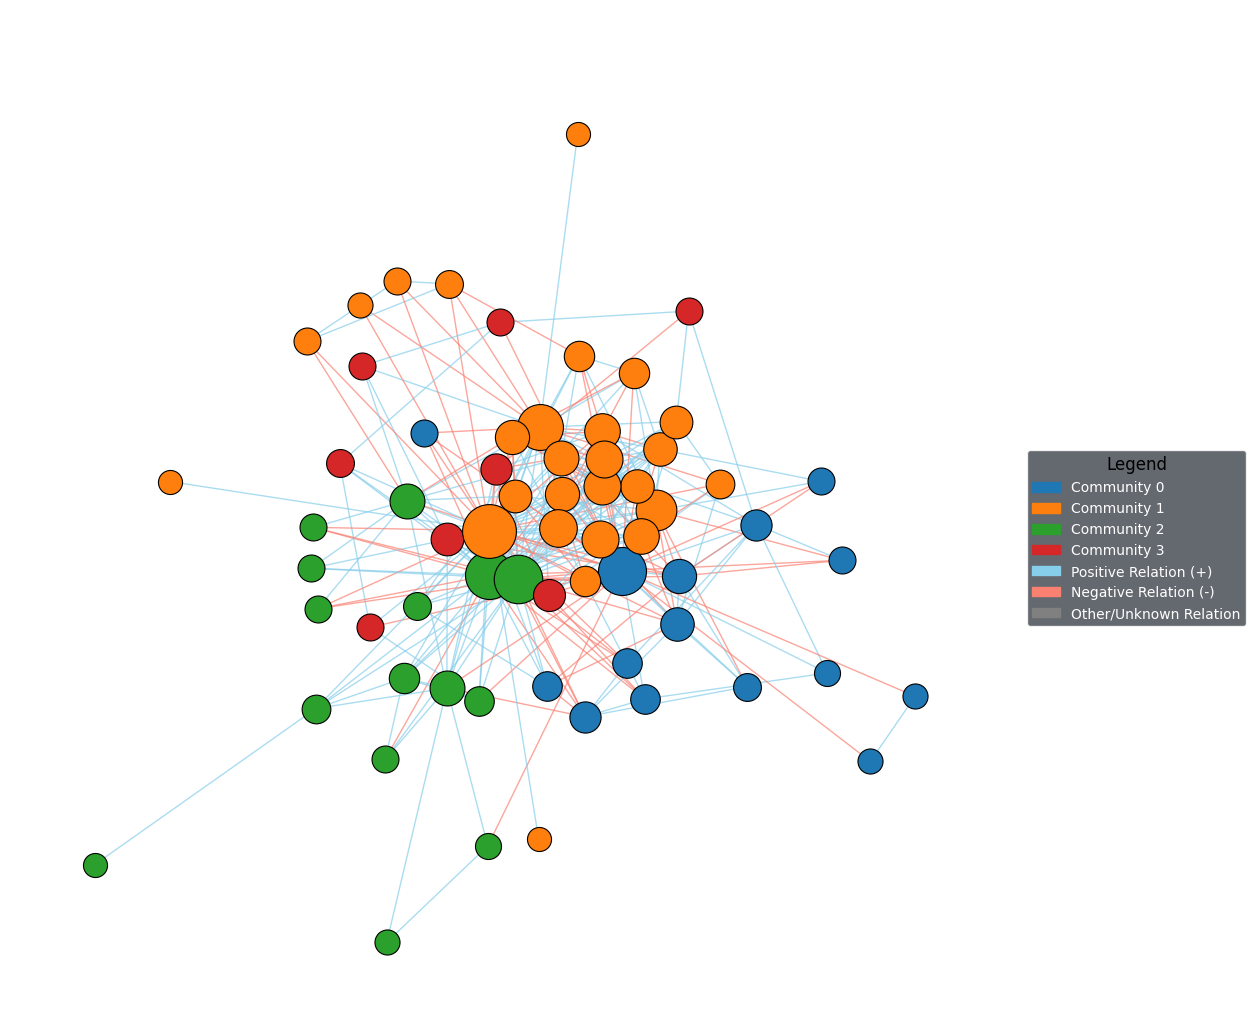


--- Visualizing Weighted Communities with Simple Matplotlib Viz ---


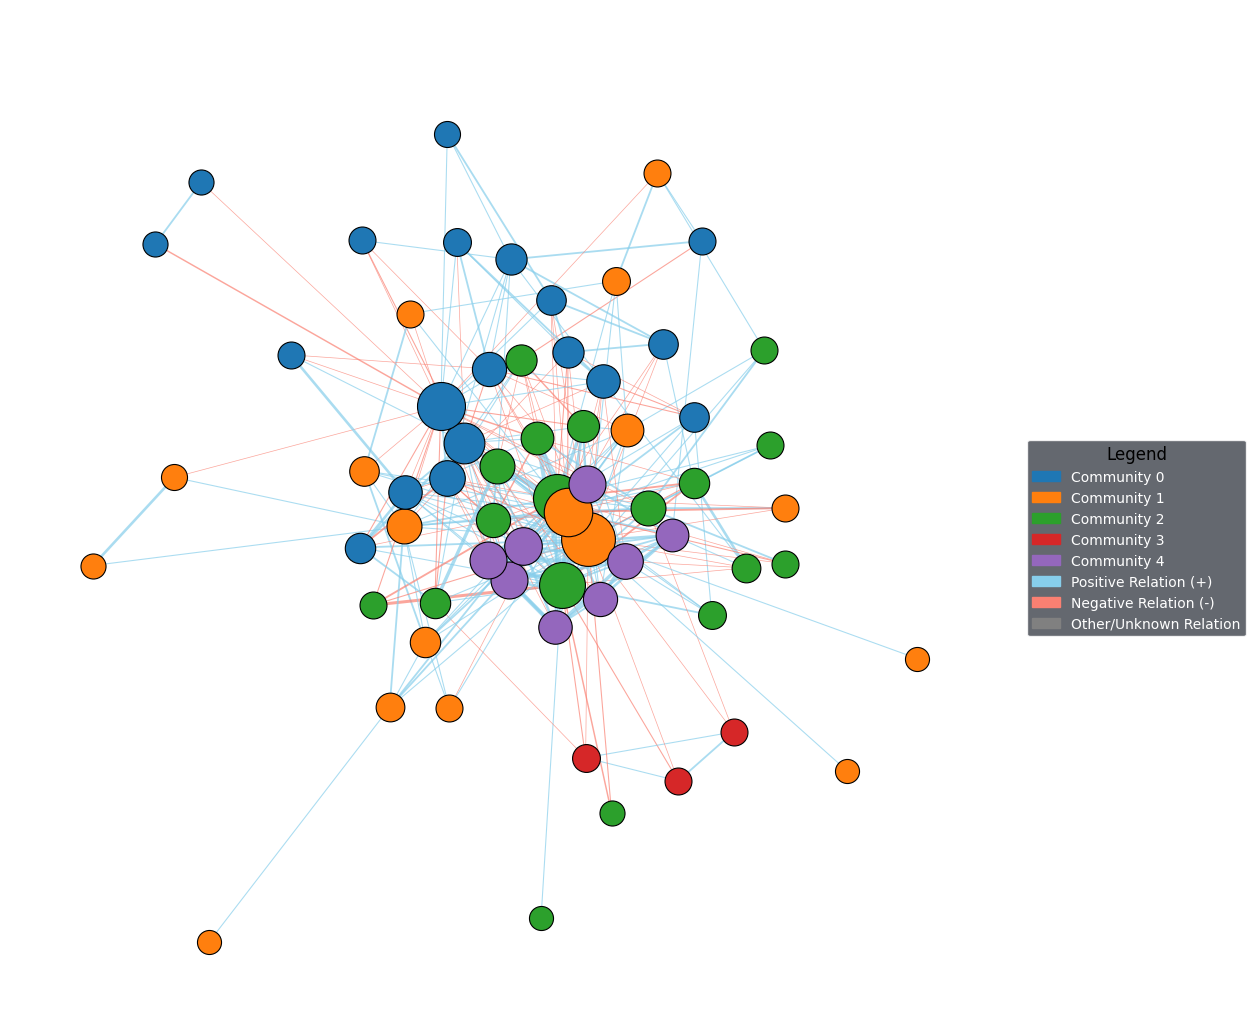


Analysis complete.


In [13]:
print("\n--- Visualizing Unweighted Communities with Simple Matplotlib Viz ---")
simple_matplotlib_viz(g, clusters_unweighted, "Harry Potter Unweighted Communities (Matplotlib)",
                      use_edge_weights_for_width=False, enable_community_shading=False)

if clusters_weighted is not None:
    print("\n--- Visualizing Weighted Communities with Simple Matplotlib Viz ---")
    simple_matplotlib_viz(g, clusters_weighted, "Harry Potter Weighted Communities (Matplotlib)",
                          use_edge_weights_for_width=True, enable_community_shading=False)
else:
    print("\nSkipping weighted community visualization with Simple Matplotlib Viz.")

print("\nAnalysis complete.")

### Conclusions

This side-by-side comparison of the unweighted and weighted Fast Greedy clustering results provides excellent insight into the network structure of Harry Potter. Some of the key findings include:

- Weighted Analysis Significantly Improves Modularity and Community Definition:

     Most striking is the considerable enhancement of modularity from 0.2334 (unweighted) to 0.3440 (weighted). This is the clear evidence that utilizing the "type" (positive/negative) of relations as weights allows the Fast Greedy algorithm to identify a much stronger, more solid, and internally denser community structure. The communities within the weighted graph are more closely linked within themselves and more clearly separated from each other.

- More Granularity with Weighting:
    
    The 4 communities discovered earlier increased to 5 when weights were considered.


  This suggests that weighting enables the algorithm to identify finer-grained groups that might have been merged together in the less granular unweighted representation. The creation of distinct "Dursley Family" and "Weasley Family" communities in the weighted analysis (Communities 3 and 4) is a great example of this increased granularity, reflecting their strong internal family connections.

- Weighted Analysis Reveals Concealed Dynamics and Modifies Essential Character Affiliations:

    - Stable Core Groups: Harry Potter, Hermione Granger, Lord Voldemort, Draco Malfoy, Bellatrix Lestrange, and Rubeus Hagrid remained in the same group with or without weights applied.
    This indicates their strong and central membership within their respective primary groups (Harry/Hermione with core "good" student group, Voldemort/Malfoy/Lestrange with "dark" group, Hagrid with general Hogwarts/student support). Their membership in a community is robust to the introduction of relationship strength.
    - Changing Roles and Complex Ties: The movement of Ron Weasley, Albus Dumbledore, and Severus Snape between communities with the introduction of weights is very significant: 
        - Ron Weasley: Switched from "Unweighted Community 2" (Hogwarts students/Hagrid's friends) to "Weighted Community 1" (Harry's friends/Triwizard individuals). This means that while his unweighted connections place him broadly among other students, his specific weighted friendships (especially strong positive ones with Harry and Hermione) pull him into a tighter inner circle around Harry, along with other key student friends.
        - Albus Dumbledore and Severus Snape: Both moved from "Unweighted Community 1" (large 'good guys' group) to "Weighted Community 2" (Dumbledore's Allies/Hogwarts Staff/Ministry).
    This new community in the weighted network appears to be a more elite "adult/authority" group.

    Their movement suggests that their weighted associations (complex, often strategically positive or negative) place them more precisely among other characters at the heart of the greater magical institution, rather than in the more general "good" cluster of the unweighted graph.
    This is suggestive of subtle, even hidden, affiliations that weights can reveal for characters with complex loyalties like Snape. 

- Quantitative Difference Confirms Qualitative Changes: 
    - The Adjusted Mutual Information (AMI) of 0.2294 (close to 0 instead of 1) and Variation of Information (VI) of 1.7248 (distant from 0) further quantitatively confirm that the community assignments of the unweighted and weighted Fast Greedy algorithms are actually quite different. Although there is some structural similarity underlying, the exact partitions and memberships have been quite re-arranged by taking edge weights into account. In conclusion, the analysis clearly demonstrates that edge weighting is necessary to obtain more meaningful and more detailed community structures in the Harry Potter network using the Fast Greedy algorithm.


    Not only does it improve the statistical quality of the partition (higher modularity), but also, it provides richer insights into the exact allegiances and roles of characters, making subtle but important differences in the way that characters are grouped when both intensity and nature of their relationships are considered.

  
The weighted Fast Greedy results provide a more nuanced reflection of the complex social life of the wizarding world.
